In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [3]:
colors = loadmat('data/color150.mat')['colors']

def colorEncode(labelmap, mode='RGB'):
    labelmap = labelmap.astype('int')
    labelmap_rgb = np.zeros((labelmap.shape[0], labelmap.shape[1], 3),
                            dtype=np.uint8)
    for label in np.unique(labelmap):
        if label < 0:
            continue
        labelmap_rgb += (labelmap == label)[:, :, np.newaxis] * \
            np.tile(colors[label],
                    (labelmap.shape[0], labelmap.shape[1], 1))

    if mode == 'BGR':
        return labelmap_rgb[:, :, ::-1]
    else:
        return labelmap_rgb

# Load Data

In [4]:
data_dir = '/scratch/shantanu/gibson4/new'
sem_dir = '/scratch/shantanu/gibson4/semantics'

scenes = os.listdir(data_dir)
print(len(scenes))

88


In [5]:
camera = 'front'
scene = scenes[1]
traj_idx = 0

filenames = [os.path.splitext(x)[0] for x in os.listdir(os.path.join(data_dir, scene, '0', camera, 'RGB'))]

print(len(filenames))

184


Andover front 1


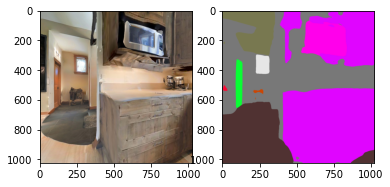

In [6]:
fileidx = 2

print(scene, camera, filenames[fileidx])

rgb = cv2.imread(os.path.join(data_dir, scene, '0', camera, 'RGB', '{}.jpg'.format(filenames[fileidx])), -1)
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

depth = cv2.imread(os.path.join(data_dir, scene, '0', camera, 'DEPTH', '{}.png'.format(filenames[fileidx])), -1)
depth = depth / 6553.5

semantics = cv2.imread(os.path.join(sem_dir, scene, '0', camera, 'semantics', '{}.png'.format(filenames[fileidx])), -1)

semanticsColor = colorEncode(semantics) # np.copy(rgb) 

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(rgb)
ax[1].imshow(semanticsColor)

# Method 1

In [318]:
full_res_shape = (1024, 1024)
hfov = 90
f = full_res_shape[0]/ (2 * np.tan(np.deg2rad(hfov/2)))
cx, cy = full_res_shape[0] // 2, full_res_shape[1] // 2

K = np.array([
    [f, 0, cx],
    [0, f, cy],
    [0, 0, 1]])
K

array([[512.,   0., 512.],
       [  0., 512., 512.],
       [  0.,   0.,   1.]])

In [319]:
y_coords, x_coords = np.indices(depth.shape)

sensor_coords = np.stack([x_coords, y_coords, np.ones_like(x_coords)])

image_coords = (np.linalg.inv(K) @ sensor_coords.reshape((3, -1))).reshape((3, *full_res_shape))

camera_coords = depth * image_coords

163267
0.9905359308949194 0.02923772624045339


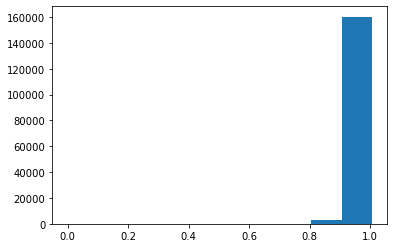

In [320]:
# Validate floor y-coordinate (height) == 1m

floor_pts = camera_coords[:,  semantics == 3]
print(floor_pts.shape[1])

print(np.mean(floor_pts[1]), np.std(floor_pts[1]))
plt.hist(floor_pts[1])
plt.show()

## Project semantic point cloud to floor

In [321]:
# Filter points above height threshold

obstacle_height_thresh = 0.1  # in m, measured from camera and not ground

filter_idx = camera_coords[1] > -obstacle_height_thresh # Since y-axis points downwards in camera-coordinate frame
filter_idx = filter_idx & (camera_coords[2] != 0) # Since depth is zero at some points
valid_pts = camera_coords[:, filter_idx]
valid_semantics = semantics[filter_idx]
valid_semanticsColor = semanticsColor[filter_idx]

print(valid_pts.shape)

flattened_pts = np.copy(valid_pts)
flattened_pts[1] = 1  # Project to floor

(3, 550826)


### Generate bev using point cloud

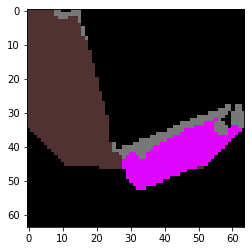

In [322]:
cw = ch = 0.05
px = 1.6  # offset along x-axis
pz = 3.3 # offset along z-axis

r = int(2 * px/ch)

T = np.array([
    [1/cw, 0, 0, px/cw],
    [0, 1, 0, 0],
    [0, 0, -1/ch, pz/ch]
])

# Discretize point coordinates to take highest per bin
discrete_coords = T @ np.concatenate([valid_pts, np.ones((1, valid_pts.shape[1]))])
filter_idx = (discrete_coords[0] > 0) & (discrete_coords[0] < r) & (discrete_coords[2] > 0) & (discrete_coords[2] < r)
discrete_coords = discrete_coords[:, filter_idx]

x_indices = discrete_coords[0].astype(np.uint32)
z_indices = discrete_coords[2].astype(np.uint32)

indices =  z_indices * r + x_indices

sorting_keys = (z_indices * r * 10) + (x_indices * 10) - discrete_coords[1]
sorting_order = np.argsort(sorting_keys)

sorted_indices = indices[sorting_order]
unique_max_filter = sorted_indices[1:] != sorted_indices[:-1]
unique_max_filter = np.concatenate([unique_max_filter, [True]])

filtered_indices = sorted_indices[unique_max_filter]

bev_x, bev_z = filtered_indices % r, filtered_indices // r
bev = np.zeros((r, r, 3), dtype=np.uint8)
filtered_semanticsColor = valid_semanticsColor[filter_idx][sorting_order][unique_max_filter]
bev[bev_z, bev_x] = filtered_semanticsColor

plt.imshow(bev, interpolation='none')

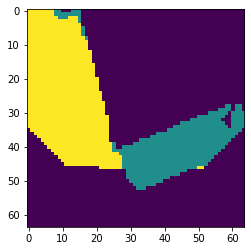

In [323]:
filtered_semantics = valid_semantics[filter_idx][sorting_order][unique_max_filter]

tmp = np.ones((r,r), dtype=np.int32) * -1
tmp[bev_z, bev_x] = filtered_semantics

bev_pc = np.zeros((r,r), dtype=np.uint8)
bev_pc[tmp != -1] = 127
bev_pc[tmp == 3] = 255

plt.imshow(bev_pc, interpolation='none')

## Reproject to image plane

In [324]:
img_w, img_h = 128, 128
K = np.array([
    [img_w//2, 0, img_w//2],
    [0, img_w//2, img_h//2],
    [0, 0, 1]])

In [325]:
img_coords = valid_pts / valid_pts[2]
sensor_coords = (K @ img_coords).astype(np.uint32)

org_x_coords, org_y_coords, _ = np.clip(sensor_coords, 0, img_w - 1)

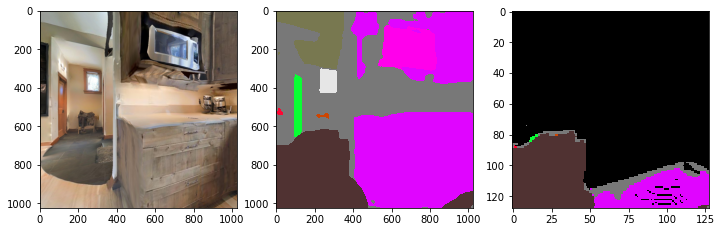

In [326]:
# Reproject to image plane

img_coords = flattened_pts / flattened_pts[2]
sensor_coords = (K @ img_coords).astype(np.uint32)

## TODO : Replace this with filter to remove points outside the sensor grid.
x_coords, y_coords, _ = np.clip(sensor_coords, 0, img_w - 1)

sensor_indices = y_coords * full_res_shape[0] + x_coords

sorting_keys = (y_coords * full_res_shape[0] * 10) + (x_coords * 10) - valid_pts[1]
sorting_order = np.argsort(sorting_keys)

sorted_sensor_indices = sensor_indices[sorting_order]
unique_max_filter = sorted_sensor_indices[:-1] != sorted_sensor_indices[1:] 
unique_max_filter = np.concatenate([unique_max_filter, [True]])

filtered_indices = sorted_sensor_indices[unique_max_filter]
x_coords, y_coords = filtered_indices % full_res_shape[1], filtered_indices // full_res_shape[1]

sorted_semantics = valid_semanticsColor[sorting_order]
filtered_semantics = sorted_semantics[unique_max_filter]
filt_org_y_coords = org_y_coords[sorting_order][unique_max_filter]

# filtered_semantics = np.copy(valid_semantics)

pers_semocc_map = np.zeros((img_h, img_w, 3), dtype=np.uint8)
pers_semocc_map[y_coords, x_coords] = filtered_semantics #valid_semantics

fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
ax[0].imshow(rgb)
ax[1].imshow(semanticsColor, interpolation='none')
ax[2].imshow(pers_semocc_map, interpolation='none')

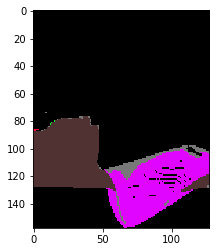

In [327]:
test_xc, test_yc, _ = sensor_coords

x_range = np.max(test_xc) + 1
y_range = np.max(test_yc) + 1

test = np.zeros((y_range, x_range, 3)).astype(np.uint16)

test[test_yc, test_xc] = valid_semanticsColor

plt.imshow(test, interpolation='none')

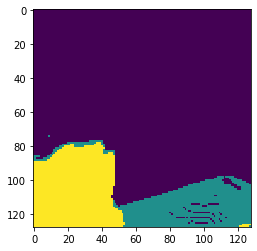

In [328]:
tmp = np.ones((img_h, img_w)).astype(np.int16) * -1

sorted_semantics = valid_semantics[sorting_order]
filtered_semantics = sorted_semantics[unique_max_filter]

tmp[y_coords, x_coords] = filtered_semantics

pers_occ_map = np.zeros((img_h, img_w)).astype(np.uint8)
pers_occ_map[tmp != -1] = 127
pers_occ_map[tmp == 3] = 255

plt.imshow(pers_occ_map, interpolation='none')

## Alternate filtering and projection method

In [329]:
# Filter points above height threshold

obstacle_height_thresh = 0.1  # in m, measured from camera and not ground

filter_idx = camera_coords[1] > -obstacle_height_thresh # Since y-axis points downwards in camera-coordinate frame
filter_idx = filter_idx & (camera_coords[2] != 0)
valid_pts = camera_coords[:, filter_idx]  
valid_semantics = semantics[filter_idx]
valid_semanticsColor = semanticsColor[filter_idx]

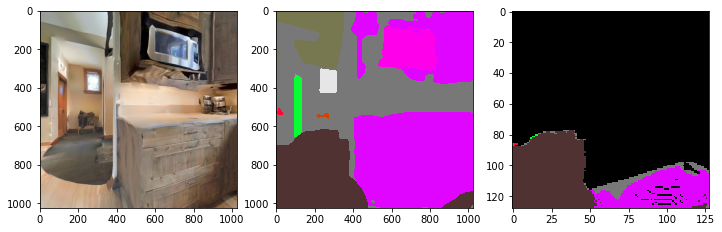

In [331]:
cw = ch = 0.00125
px = 5  # offset along x-axis
pz = 10 # offset along z-axis

r = int(pz/ch)

T = np.array([
    [1/cw, 0, 0, px/cw],
    [0, 1, 0, 0],
    [0, 0, -1/ch, pz/ch]
])

# Discretize point coordinates to take highest per bin
discrete_coords = T @ np.concatenate([valid_pts, np.ones((1, valid_pts.shape[1]))])
discrete_coords = discrete_coords[:, (discrete_coords[0] > 0) & (discrete_coords[2] > 0)]

x_indices = discrete_coords[0].astype(np.uint32)
z_indices = discrete_coords[2].astype(np.uint32)

indices =  z_indices * r + x_indices

sorting_keys = (z_indices * r * 10) + (x_indices * 10) - discrete_coords[1]
sorting_order = np.argsort(sorting_keys)

sorted_indices = indices[sorting_order]
unique_max_filter = sorted_indices[1:] != sorted_indices[:-1]
unique_max_filter = np.concatenate([unique_max_filter, [True]])

filtered_pts = valid_pts[:, sorting_order][:, unique_max_filter]
filtered_semantics = valid_semanticsColor[sorting_order][unique_max_filter]

filtered_pts[1] = 1
img_coords = filtered_pts / filtered_pts[2]
sensor_coords = (K @ img_coords).astype(np.uint32)

x_coords, y_coords, _ = np.clip(sensor_coords, 0, img_w - 1)

pers_semocc_map2 = np.zeros((img_h, img_w, 3), dtype=np.uint8)
pers_semocc_map2[y_coords, x_coords] = filtered_semantics

fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
ax[0].imshow(rgb)
ax[1].imshow(semanticsColor, interpolation='none')
ax[2].imshow(pers_semocc_map2, interpolation='none')

# Method 2

## Use groundtruth bev (simulator) to generate perspective occupancy

(64, 64)


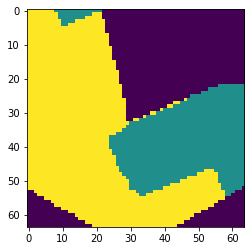

In [332]:
bev_fp = '/scratch/shantanu/gibson4/dilated_partialmaps/{}/{}/partial_occ/{}.png'.format(
    scene, camera, filenames[fileidx])

bev = cv2.imread(bev_fp, -1)
bev = bev[64:, 32:96]  # Crop 3.2 x 3.2m with resolution 0.05m/px
print(bev.shape)

plt.imshow(bev, interpolation='none')

In [333]:
high_res_bev = cv2.resize(bev, (256, 256), interpolation=cv2.INTER_NEAREST)
new_res = 0.05/4
print(new_res)

0.0125


In [334]:
z_coord, x_coord = np.indices(high_res_bev.shape)
z_coord = (high_res_bev.shape[0] - z_coord) * new_res + 0.1
x_coord = (x_coord - high_res_bev.shape[1]//2) * new_res

camera_height = 1
y_coord = np.ones_like(x_coord) * camera_height 

camera_coords = np.stack([x_coord, y_coord, z_coord]).reshape((3, -1))

Text(0.5, 1.0, 'pers_proj')

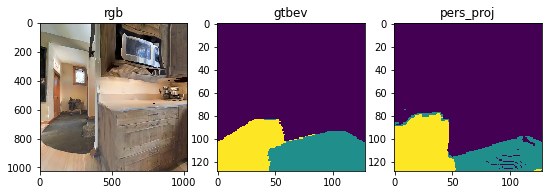

In [336]:
img_w, img_h = 128, 128
K = np.array([
    [img_w//2, 0, img_w//2],
    [0, img_w//2, img_h//2],
    [0, 0, 1]])

img_coords = camera_coords / camera_coords[2]
sensor_coords = (K @ img_coords)

x_coords, y_coords, _ = sensor_coords
filter_idx = (x_coords >= 0) & (x_coords < img_w) & (y_coords >= 0) & (y_coords < img_h)
# filter_idx = filter_idx & (high_res_bev.flatten() == 255)

x_coords = x_coords[filter_idx].astype(np.uint16)
y_coords = y_coords[filter_idx].astype(np.uint16)

filtered_bev = high_res_bev.flatten()[filter_idx]

semantic_map = np.zeros((img_h, img_w)).astype(np.uint8)
semantic_map[y_coords, x_coords] = filtered_bev

fig, ax = plt.subplots(ncols=3, figsize=(9, 3))
ax[0].imshow(rgb, interpolation='none')
ax[1].imshow(semantic_map, interpolation='none')
ax[2].imshow(pers_occ_map, interpolation='none')


ax[0].set_title('rgb')
ax[1].set_title('gtbev')
ax[2].set_title('pers_proj')

# Compare bev maps generated by projection

In [401]:
def proj_to_bev(sm, cam_height):
    img_w, img_h = sm.shape
    y_coords, x_coords = np.indices((img_h, img_w))
    sensor_coords = np.stack([x_coords, y_coords, np.ones_like(x_coords)])

    K = np.array([
        [img_w//2, 0, img_w//2],
        [0, img_w//2, img_h//2],
        [0, 0, 1]])

    img_coords = np.linalg.inv(K) @ sensor_coords.reshape((3, -1))

    chandrakar_depth = (cam_height * 1)/ (img_coords[1].flatten() + 1e-7)

    filter_idx = (sm.flatten() != 0) & (chandrakar_depth > 0.1) & (chandrakar_depth < 10.0)

    cam_coords = (img_coords * chandrakar_depth)[:, filter_idx]

    bev_shape = np.array([64, 64])
    bev_res = 0.05

    x_coords, _, z_coords = cam_coords
    x_coords = (x_coords/bev_res).astype(int) + bev_shape[1]//2 - 1
    z_coords = -(z_coords/bev_res).astype(int) + bev_shape[0] - 1

    bev_filter = (x_coords > 0) & (x_coords < bev_shape[1]) & (z_coords > 0) & (z_coords < bev_shape[0])
    x_coords = x_coords[bev_filter]
    z_coords = z_coords[bev_filter]

    bev_class = sm.flatten()[filter_idx][bev_filter]

    bev_proj = np.zeros(bev_shape, dtype=np.uint8)
    bev_proj[z_coords, x_coords] = bev_class
    
    return bev_proj

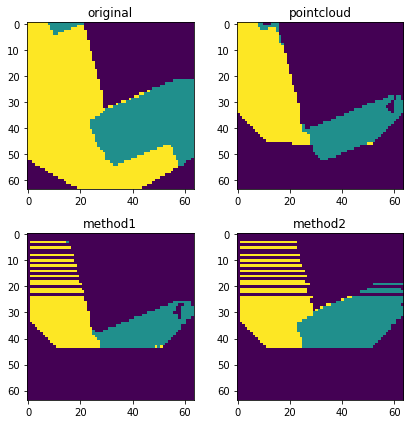

In [403]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6, 6))
ax = ax.flatten()
ax[0].imshow(bev, interpolation='none')
ax[1].imshow(bev_pc, interpolation='none')
ax[2].imshow(proj_to_bev(pers_occ_map, 1), interpolation='none')
ax[3].imshow(proj_to_bev(semantic_map, 1), interpolation='none')


ax[0].set_title('original')
ax[1].set_title('pointcloud')
ax[2].set_title('method1')
ax[3].set_title('method2')

plt.tight_layout()
plt.show()

# Evalaute generated data qualitatively

In [9]:
import sys

PROJECT_DIR = '/home/shantanu.singh/perspective_occupancy_map'

if PROJECT_DIR not in sys.path:
    sys.path.append(PROJECT_DIR)
    
from utils.layout_utils import mean_IU, mean_precision, union
from preprocessing.generate_perspective_occupancy_maps import FLOOR_INDICES

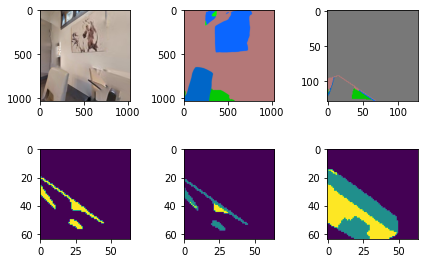

In [10]:
scene, camera, fileidx = 'Reyno front 698'.split()

sem = cv2.imread(f'/scratch/shantanu/gibson4/new/{scene}/0/{camera}/semantics/{fileidx}.png', -1)
colorsem = colorEncode(sem)

rgb = cv2.imread(f'/scratch/shantanu/gibson4/new/{scene}/0/{camera}/RGB/{fileidx}.jpg', -1)
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

visible_bev = cv2.imread(f'/scratch/shantanu/gibson4/dilated_partialmaps/{scene}/{camera}/visible_gt/{fileidx}.png', -1)
visible_bev = visible_bev[64:, 32:96]

partial_occ = cv2.imread(f'/scratch/shantanu/gibson4/dilated_partialmaps/{scene}/{camera}/partial_occ/{fileidx}.png', -1)
partial_occ = partial_occ[64:, 32:96]

bev_proj = cv2.imread(f'/scratch/shantanu/gibson4/generated/{scene}/{camera}/proj_bev/{fileidx}.png', -1)
bev_proj2 = np.zeros_like(bev_proj).astype(np.uint8)
bev_proj2[bev_proj!=0] = 127
bev_proj2[np.isin(bev_proj, FLOOR_INDICES)] = 255

pop = cv2.imread(f'/scratch/shantanu/gibson4/generated/{scene}/{camera}/pom/{fileidx}.png', -1)
pop2 = np.zeros_like(pop).astype(np.uint8)
pop2[pop!=0] = 127
pop2[np.isin(pop, FLOOR_INDICES)] = 255

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(6, 4))
ax = ax.flatten()
ax[0].imshow(rgb)
ax[1].imshow(colorEncode(sem+1))
ax[2].imshow(colorEncode(pop))
ax[3].imshow(visible_bev)
ax[4].imshow(bev_proj2)
ax[5].imshow(partial_occ)

plt.tight_layout()
plt.show()

# Evalaute generated data quantitatively

In [11]:
data_dir = '/scratch/shantanu/gibson4/new'
camera = 'front'

eval_inputs = ['{} {} {}'.format(scene, camera, os.path.splitext(x)[0])
     for scene in os.listdir(data_dir)
     for x in os.listdir(os.path.join(data_dir, scene, '0', camera, 'RGB'))]

## Visible region overlap

In [12]:
tgt_fp = '/scratch/shantanu/gibson4/dilated_partialmaps/{}/{}/visible_gt/{}.png'
gen_fp = '/scratch/shantanu/gibson4/generated/{}/{}/pom/{}.png'

iu_scores = np.empty((len(eval_inputs), 2))
tgt_cls_pct = np.empty((len(eval_inputs), 2))
pred_cls_pct = np.empty((len(eval_inputs), 2))
union_scores = np.empty((len(eval_inputs), 2))

for idx, item in enumerate(eval_inputs):
    scene, camera, fileidx = item.split()

    bev = cv2.imread(f'/scratch/shantanu/gibson4/dilated_partialmaps/{scene}/{camera}/visible_gt/{fileidx}.png', -1)
    bev = bev[64:, 32:96] // 255

    bev_proj = cv2.imread(f'/scratch/shantanu/gibson4/generated/{scene}/{camera}/proj_bev/{fileidx}.png', -1)
    bev_proj = (bev_proj != 0).astype(np.uint8)
        
    iu_scores[idx] = mean_IU(bev_proj, bev, 2)
    union_scores[idx] = union(bev_proj, bev, 2)
    
    tgt_cls_pct[idx] = np.array([np.sum(bev == 0), np.sum(bev == 1)]) / bev.size
    pred_cls_pct[idx] = np.array([np.sum(bev_proj == 0), np.sum(bev_proj == 1)]) / bev_proj.size

In [13]:
np.mean(iu_scores, axis=0)

array([0.94117095, 0.81048624])

(array([ 127.,  169.,  181.,  237.,  276.,  336.,  451.,  694., 1360.,
        2923.]),
 array([0.        , 0.0799884 , 0.1599768 , 0.2399652 , 0.3199536 ,
        0.399942  , 0.47993039, 0.55991879, 0.63990719, 0.71989559,
        0.79988399]),
 <BarContainer object of 10 artists>)

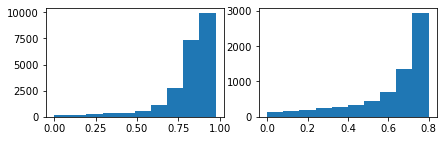

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(7,2))

ax[0].hist(iu_scores[:, 1])
ax[1].hist(iu_scores[iu_scores[:, 1] < 0.8][:, 1])

6754


(array([2066., 1498., 1248.,  856.,  514.,  322.,  152.,   72.,   20.,
           6.]),
 array([ 0.36621094,  5.92285156, 11.47949219, 17.03613281, 22.59277344,
        28.14941406, 33.70605469, 39.26269531, 44.81933594, 50.37597656,
        55.93261719]),
 <BarContainer object of 10 artists>)

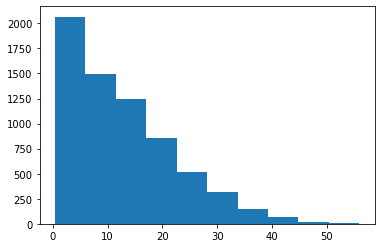

In [15]:
print(union_scores[(iu_scores[:, 1] < 0.8)].shape[0])
plt.hist(union_scores[(iu_scores[:, 1] < 0.8)][:, 1] * 100/ bev.size)

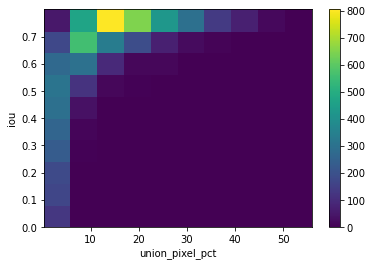

In [16]:
plt.hist2d(union_scores[(iu_scores[:, 1] < 0.8), 1] * 100/bev.size, 
           iu_scores[(iu_scores[:, 1] < 0.8), 1])
ax = plt.gca()
ax.set_xlabel('union_pixel_pct')
ax.set_ylabel('iou')
plt.colorbar()
plt.show()

0.9219978284473398
[0.93740746 0.84775299]


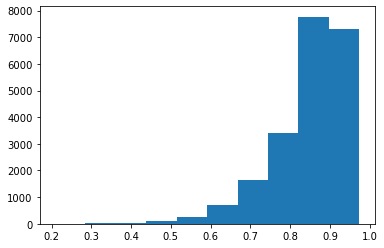

In [17]:
flt_iu_scores = iu_scores[(union_scores[:, 1] > 0.05 * bev.size)]
print(flt_iu_scores.shape[0] / iu_scores.shape[0])

print(np.mean(flt_iu_scores, axis=0))

plt.hist(flt_iu_scores[:, 1])
plt.show()

In [18]:
indices = np.arange(len(eval_inputs))[(union_scores[:, 1] > 0.05 * bev.size)]
sorted_indices = sorted(indices, key=lambda x: iu_scores[x, 1])

[(eval_inputs[x], iu_scores[x]) for x in sorted_indices][:10]

[('Scioto front 277', array([0.8476384 , 0.20844327])),
 ('Springhill front 132', array([0.52405063, 0.24227497])),
 ('Nemacolin front 280', array([0.95339613, 0.248     ])),
 ('Scioto front 278', array([0.84350064, 0.25763126])),
 ('Scioto front 280', array([0.95481629, 0.272     ])),
 ('Goffs front 520', array([0.89673636, 0.30051813])),
 ('Goffs front 519', array([0.94164788, 0.30654762])),
 ('Mesic front 72', array([0.94545909, 0.31230284])),
 ('Reyno front 698', array([0.94692038, 0.32484076])),
 ('Scioto front 279', array([0.94971228, 0.33      ]))]

0.8516395222584148
[0.93597901 0.86667211]


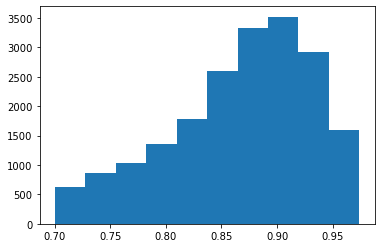

In [19]:
flt_iu_scores2 = flt_iu_scores[(flt_iu_scores[:, 1] > 0.7)]
indices2 = indices[(flt_iu_scores[:, 1] > 0.7)]
print(len(indices2) / len(eval_inputs))
print(np.mean(flt_iu_scores2, axis=0))

plt.hist(flt_iu_scores2[:, 1])
plt.show()

## Partial occupancy IOU

In [74]:
iu_scores = np.empty((len(eval_inputs), 3))
union_scores = np.empty((len(eval_inputs), 3))

for idx, item in enumerate(eval_inputs):
    scene, camera, fileidx = item.split()

    bev = cv2.imread(f'/scratch/shantanu/gibson4/dilated_partialmaps/{scene}/{camera}/partial_occ/{fileidx}.png', -1)
    bev = bev[64:, 32:96] // 127

    sem_bev_proj = cv2.imread(f'/scratch/shantanu/gibson4/generated/{scene}/{camera}/proj_bev/{fileidx}.png', -1)
    bev_proj = np.zeros_like(bev)
    bev_proj[sem_bev_proj != 0] = 1
    bev_proj[np.isin(sem_bev_proj, FLOOR_INDICES)] = 2
        
    iu_scores[idx] = mean_IU(bev_proj, bev, 3)
    union_scores[idx] = union(bev_proj, bev, 3)

In [76]:
np.mean(iu_scores, axis=0)

array([0.51347726, 0.27233656, 0.39699838])

(array([3575., 1384., 1775., 2336., 3040., 3788., 3952., 2519.,  605.,
          51.]),
 array([0.        , 0.09143956, 0.18287913, 0.27431869, 0.36575826,
        0.45719782, 0.54863738, 0.64007695, 0.73151651, 0.82295608,
        0.91439564]),
 <BarContainer object of 10 artists>)

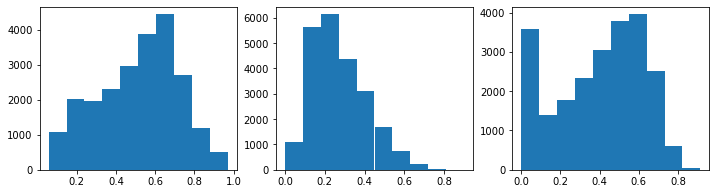

In [78]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

ax[0].hist(iu_scores[:, 0])
ax[1].hist(iu_scores[:, 1])
ax[2].hist(iu_scores[:, 2])

[0.47321069 0.28903787 0.45743856]


(array([ 924.,  919., 1561., 2276., 3021., 3781., 3952., 2519.,  605.,
          51.]),
 array([0.        , 0.09143956, 0.18287913, 0.27431869, 0.36575826,
        0.45719782, 0.54863738, 0.64007695, 0.73151651, 0.82295608,
        0.91439564]),
 <BarContainer object of 10 artists>)

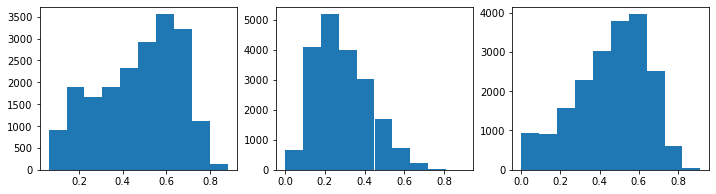

In [84]:
iu_scores2 = np.empty((len(indices2), 3))
union_scores2 = np.empty((len(indices2), 3))

for idx, item in enumerate(np.array(eval_inputs)[indices2]):
    scene, camera, fileidx = item.split()

    bev = cv2.imread(f'/scratch/shantanu/gibson4/dilated_partialmaps/{scene}/{camera}/partial_occ/{fileidx}.png', -1)
    bev = bev[64:, 32:96] // 127

    sem_bev_proj = cv2.imread(f'/scratch/shantanu/gibson4/generated/{scene}/{camera}/proj_bev/{fileidx}.png', -1)
    bev_proj = np.zeros_like(bev)
    bev_proj[sem_bev_proj != 0] = 1
    bev_proj[np.isin(sem_bev_proj, FLOOR_INDICES)] = 2
        
    iu_scores2[idx] = mean_IU(bev_proj, bev, 3)
    union_scores2[idx] = union(bev_proj, bev, 3)
    
print(np.mean(iu_scores2, axis=0))

fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

ax[0].hist(iu_scores2[:, 0])
ax[1].hist(iu_scores2[:, 1])
ax[2].hist(iu_scores2[:, 2])

# Generate Training/Test split

Download the gibson4+ split information using:
https://dl.fbaipublicfiles.com/habitat/data/datasets/pointnav/gibson/v2/pointnav_gibson_v2.zip

This link comes from #3 :
https://github.com/facebookresearch/habitat-challenge/tree/challenge-2020#pointnavobjectnav-baselines-and-dd-ppo-training-starter-code

In [7]:
split_dir = '/scratch/shantanu/gibson4/habitat_data'

In [29]:
train_scenes = [x.split('.')[0] for x in os.listdir(
    os.path.join(split_dir, 'train', 'content'))]

test_scenes = [x.split('.')[0] for x in os.listdir(
    os.path.join(split_dir, 'val', 'content'))]

print(len(train_scenes), len(test_scenes))

72 14


In [32]:
valid_inputs = np.array(eval_inputs)[indices2].tolist()

train_data = [x + '\n' for x in valid_inputs if x.split()[0] in train_scenes]
test_data = [x + '\n' for x in valid_inputs if x.split()[0] in test_scenes]

print(len(train_data), len(test_data))

16873 2662


In [33]:
with open(os.path.join(PROJECT_DIR, 'splits', 'gibson4', 'train.txt'), 'w') as f:
    f.writelines(train_data)
    
with open(os.path.join(PROJECT_DIR, 'splits', 'gibson4', 'test.txt'), 'w') as f:
    f.writelines(test_data)